# Lane Detection with TuSimple Dataset
Using U-Net
1. Configuration
2. Data Preprocessing (JSON to Masks)
3. Dataset Loading
4. Model Architecture (U-Net)
5. Training Loop
6. Inference & Visualization
7. Execution
8. Evaluation

Save the Confusion Matrix while the validation

differentiation of lanes: arc loss, distance between lanes. 
last layer 
instance segmentation

+3 credits: from instance segmentation -> shape of lane markings scipy make_splprep

## 1. Configuration
Define paths, hyperparameters, and device settings.


In [54]:
import os
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import Image

BASE_DIR = os.getcwd()
DATA_DIR = r'C:\Users\Alex\Documents\Clase\Italia\Segundo_ano\ADAS\Project\TU_Simple_folder\TUSimple' 
TRAIN_SET_DIR = os.path.join(DATA_DIR, 'train_set')
TEST_SET_DIR = os.path.join(DATA_DIR, 'test_set')
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, r'processed\instance')
CHECKPOINT_DIR = os.path.join(BASE_DIR, r'checkpoints\instance')

os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Hyperparameters
EPOCHS = 20
BATCH_SIZE = 16 # Optimized for 2x T4 
LEARNING_RATE = 5*1e-4 
WEIGHT_DECAY = 1e-4 
NUM_LANE_CLASSES = 5
NUM_CLASSES = 6
IMG_HEIGHT = 288
IMG_WIDTH = 512
EXIST_THRESHOLD = 0.2 # Relaxed for better recall

model_filename = f'best_model_ghost_aug_e{EPOCHS}.pth'
BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, model_filename)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## 2. Data Preprocessing
Functions to parse TuSimple JSON labels and generate segmentation masks.


In [55]:
def process_tusimple_data(data_dir, output_dir, json_files):
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for json_file in json_files:
        json_path = os.path.join(data_dir, json_file)

        with open(json_path, 'r') as openfile:
            lines = openfile.readlines()

        for line in tqdm(lines, desc=f"Processing {json_file}"):
            info = json.loads(line)
            raw_file = info['raw_file']
            lanes = info['lanes']
            h_samples = info['h_samples']
            
            mask = np.zeros((720, 1280), dtype=np.uint8)

            for i, lane in enumerate(lanes):
                if all(x == -2 for x in lane):
                    continue
                    
                points = []
                for x, y in zip(lane, h_samples):
                    if x != -2:
                        points.append((x, y))
                
                if len(points) > 1:
                    class_id = i + 1
                    # Changed thickness from 10 to 4 for geometry aware supervision (thinner lines)
                    cv2.polylines(mask, [np.array(points, dtype=np.int32)], isClosed=False, color=class_id, thickness=4) 
                    
            mask_rel_path = raw_file.replace('.jpg', '.png')
            mask_save_path = os.path.join(output_dir, mask_rel_path)
            
            os.makedirs(os.path.dirname(mask_save_path), exist_ok=True)
            cv2.imwrite(mask_save_path, mask)

## 3. Dataset Definition
PyTorch Dataset class to load images and masks.


In [56]:
class TuSimpleDataset(Dataset):
    def __init__(self, root_dir, processed_dir, json_files, augment=False):
        self.root_dir = root_dir
        self.processed_dir = processed_dir
        self.augment = augment
        self.samples = []

        for json_file in json_files:
            json_path = os.path.join(root_dir, json_file)
            if not os.path.exists(json_path): continue
            with open(json_path, 'r') as f:
                lines = f.readlines()
            for line in lines:
                info = json.loads(line)
                self.samples.append((info['raw_file'], info['raw_file'].replace('.jpg', '.png'), info['lanes']))

    def apply_shadows(self, image):
        if random.random() > 0.5:
            top_y = random.randint(0, image.shape[0] // 2)
            bot_y = random.randint(image.shape[0] // 2, image.shape[0])
            left_x = random.randint(0, image.shape[1])
            right_x = random.randint(0, image.shape[1])
            shadow_mask = np.zeros_like(image, dtype=np.uint8)
            vertices = np.array([[(left_x, top_y), (right_x, top_y), (image.shape[1], bot_y), (0, bot_y)]], dtype=np.int32)
            cv2.fillPoly(shadow_mask, vertices, (0, 0, 0))
            alpha = random.uniform(0.1, 0.4)
            image = cv2.addWeighted(image, 1 - alpha, shadow_mask, alpha, 0)
        return image

    def apply_blur(self, image):
        r = random.random()
        if r > 0.8: # Gaussian Blur
            image = cv2.GaussianBlur(image, (5, 5), 0)
        elif r > 0.6: # Motion Blur
            size = 15
            kernel_v = np.zeros((size, size))
            kernel_v[:, int((size - 1)/2)] = np.ones(size)
            kernel_v /= size
            image = cv2.filter2D(image, -1, kernel_v)
        return image

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_rel, mask_rel, lanes_raw = self.samples[idx]
        image = cv2.imread(os.path.join(self.root_dir, img_rel))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.processed_dir, mask_rel), cv2.IMREAD_GRAYSCALE)

        # ROI Crop: Focus on road (bottom 2/3)
        h, w = image.shape[:2]
        crop_top = int(h * 0.25)
        image = image[crop_top:, :]
        mask = mask[crop_top:, :]

        if self.augment:
            image = self.apply_shadows(image)
            image = self.apply_blur(image)
            # Pixel level transforms (using PIL/Torchvision for convenience)
            img_pil = Image.fromarray(image)
            img_pil = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2)(img_pil)
            # Synchronized Geometric Transforms
            mask_pil = Image.fromarray(mask)
            if random.random() > 0.5:
                angle = random.uniform(-5, 5)
                img_pil = TF.rotate(img_pil, angle)
                mask_pil = TF.rotate(mask_pil, angle)
            if random.random() > 0.7:
                img_pil = TF.hflip(img_pil)
                mask_pil = TF.hflip(mask_pil)
                # Note: horizontal flip swaps lane IDs for instance seg, but for 5 binary heads it works unless side matters.
                # Since we predict 5 independent maps, we assume lane order is consistent in images.
            image = np.array(img_pil)
            mask = np.array(mask_pil)

        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
        image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
        
        b_masks = np.zeros((NUM_LANE_CLASSES, IMG_HEIGHT, IMG_WIDTH), dtype=np.float32)
        existence = [0] * NUM_LANE_CLASSES
        for i in range(NUM_LANE_CLASSES):
            m_i = (mask == (i + 1))
            b_masks[i] = m_i.astype(np.float32)
            if m_i.sum() > (IMG_HEIGHT * IMG_WIDTH * 0.0001): # Tiny threshold for existence in cropped view
                existence[i] = 1
        
        return image, torch.from_numpy(b_masks), torch.tensor(existence, dtype=torch.float32)


## 4. Model Architecture (U-Net)

In [22]:
class DoubleConv(nn.Module):
    #(convolution => [BN] => ReLU) * 2
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # padding=1
        mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2) #may be used for overfitting of lane 4-5
        )

    def forward(self, x):
        return self.double_conv(x)

Encoder - downsampling:

In [23]:
class Down(nn.Module):
    #downscaling with maxpool then double conv    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # 256x256 -> 128x128
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


Decoder - upsampling:

In [24]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # upsample  
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        # x1 previous layer 
        # x2 corresponding encoder layer (skip connection)
        x1 = self.up(x1)
        
        # calculate the difference in size between x1 (upsampled) and x2 (skip connection)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        # pad x1 to match the size of x2
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # skip connection
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [25]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        # 1x1 convolution to map feature channels to the number of classes
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

Final:

In [26]:

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)       
        inputs = inputs.contiguous().view(-1)
        targets = targets.contiguous().view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

class BoundaryLoss(nn.Module):
    def __init__(self):
        super(BoundaryLoss, self).__init__()
        self.kernel = torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=torch.float32).view(1, 1, 3, 3)

    def forward(self, inputs, targets):
        device = inputs.device
        self.kernel = self.kernel.to(device)
        
        probs = torch.sigmoid(inputs)
        B, C, H, W = probs.shape
        
        # Laplacian as an edge detector
        p_edges = F.conv2d(probs.view(B*C, 1, H, W), self.kernel, padding=1).abs()
        t_edges = F.conv2d(targets.view(B*C, 1, H, W), self.kernel, padding=1).abs()
        
        return F.mse_loss(p_edges, t_edges)


In [27]:
class UNet(nn.Module): 
    def __init__(self, n_channels, n_lane_classes=5):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_lane_classes = n_lane_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        
        # Output 5 binary maps (logits)
        self.outc = OutConv(64, n_lane_classes)
        
        # Existence Head: attached to the bottleneck (down4 output) or near end
        # Let's attach to the bottleneck (1024 channels)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.exist_linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_lane_classes) # Output 5 logits for existence
        )

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4) # Bottleneck: 1024 ch
        
        # Existence branch
        exist_logits = self.exist_linear(self.gap(x5))
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        seg_logits = self.outc(x)
        
        return seg_logits, exist_logits


## 5. Training Loop


In [28]:
def train_model():
    json_files = ['label_data_0313.json', 'label_data_0531.json', 'label_data_0601.json']
    # Note: We split samples manually to have different augment settings
    full_dataset = TuSimpleDataset(TRAIN_SET_DIR, PROCESSED_DATA_DIR, json_files, augment=False)
    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_indices, val_indices = random_split(range(len(full_dataset)), [train_size, val_size])
    
    # Create separate dataset instances for train (aug) and val (no aug)
    train_dataset = TuSimpleDataset(TRAIN_SET_DIR, PROCESSED_DATA_DIR, json_files, augment=True)
    train_dataset.samples = [full_dataset.samples[i] for i in train_indices]
    
    val_dataset = TuSimpleDataset(TRAIN_SET_DIR, PROCESSED_DATA_DIR, json_files, augment=False)
    val_dataset.samples = [full_dataset.samples[i] for i in val_indices]
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    model = UNet(n_channels=3, n_lane_classes=NUM_LANE_CLASSES)
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)
    model = model.to(device)
    criterion_seg_bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0]).to(device)) # Handle extreme sparsity
    criterion_seg_dice = DiceLoss()
    criterion_boundary = BoundaryLoss()
    criterion_exist = nn.BCEWithLogitsLoss()
    
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    best_val_loss = float('inf')
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for images, b_masks, exist_targets in loop:
            images, b_masks, exist_targets = images.to(device), b_masks.to(device), exist_targets.to(device)
            seg_logits, exist_logits = model(images)
            loss_seg = criterion_seg_bce(seg_logits, b_masks) + criterion_seg_dice(seg_logits, b_masks) + 0.1 * criterion_boundary(seg_logits, b_masks)
            loss_exist = criterion_exist(exist_logits, exist_targets)
            loss = loss_seg + 0.5 * loss_exist
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())
        
        avg_val_loss = 0
        model.eval()
        with torch.no_grad():
            for images, b_masks, exist_targets in val_loader:
                images, b_masks, exist_targets = images.to(device), b_masks.to(device), exist_targets.to(device)
                seg_logits, exist_logits = model(images)
                l_seg = criterion_seg_bce(seg_logits, b_masks) + criterion_seg_dice(seg_logits, b_masks) + 0.1 * criterion_boundary(seg_logits, b_masks)
                loss = l_seg + 0.5 * criterion_exist(exist_logits, exist_targets)
                avg_val_loss += loss.item() / len(val_loader)
        
        print(f"Epoch {epoch+1}: Val Loss={avg_val_loss:.4f}")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            # Handle DataParallel saving
            state_dict = model.module.state_dict() if hasattr(model, 'module') else model.state_dict()
            torch.save(state_dict, BEST_MODEL_PATH)


## 6. Inference & Visualization


In [57]:
def apply_advanced_post_processing(seg_probs, exist_probs, img_h, img_w):
    num_classes = seg_probs.shape[0]
    res_masks = np.zeros_like(seg_probs, dtype=np.uint8)
    
    for i in range(num_classes):
        if exist_probs[i] < EXIST_THRESHOLD:
            continue
            
        mask = (seg_probs[i] > 0.5).astype(np.uint8)
        kernel = np.ones((5,5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        
        num_labels, labels_im, stats, _ = cv2.connectedComponentsWithStats(mask)
        
        # Accumulate ALL components that pass filters (fixes shortened dotted lines)
        for j in range(1, num_labels):
            area = stats[j, cv2.CC_STAT_AREA]
            top = stats[j, cv2.CC_STAT_TOP]
            height = stats[j, cv2.CC_STAT_HEIGHT]
            
            if area < 80: continue
            if height < 0.1 * img_h: continue # Relaxed height to 10%
                
            coords = np.argwhere(labels_im == j)
            y, x = coords[:, 0], coords[:, 1]
            
            try:
                poly = np.polyfit(y, x, 2)
                fit_x = np.polyval(poly, y)
                mae = np.mean(np.abs(x - fit_x))
                if mae > 15.0: continue 
                
                # Add this component to the head's mask
                res_masks[i][labels_im == j] = 1
            except:
                continue
            
    return res_masks

In [58]:
def lane_detection_prediction(image_path, model_path, output_path):
    model = UNet(n_channels=3, n_lane_classes=NUM_LANE_CLASSES).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    example_image = cv2.imread(image_path)
    full_h, full_w = example_image.shape[:2]
    
    # ROI Crop (Must match Dataset logic: crop top 25%)
    crop_top = int(full_h * 0.25)
    cropped_image = example_image[crop_top:, :]
    
    image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = image.astype(np.float32) / 255.0
    image = np.transpose(image, (2, 0, 1))
    image = torch.from_numpy(image).float().unsqueeze(0).to(device)

    with torch.no_grad():
        seg_logits, exist_logits = model(image)
        seg_probs = torch.sigmoid(seg_logits)
        exist_probs = torch.sigmoid(exist_logits)
        
    seg_probs = seg_probs.squeeze(0).cpu().numpy()
    exist_probs = exist_probs.squeeze(0).cpu().numpy()
    
    print("Existence Probs:", exist_probs)
    
    # Apply Advanced Post-Processing
    processed_masks = apply_advanced_post_processing(seg_probs, exist_probs, IMG_HEIGHT, IMG_WIDTH)
    
    overlay = np.zeros_like(example_image)
    colors = [[0, 255, 0], [255, 0, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255]]
    
    for i in range(NUM_LANE_CLASSES):
        mask = processed_masks[i]
        if np.sum(mask) > 0:
            # Resize mask to the size of the CROPPED image
            mask_resized = cv2.resize(mask, (full_w, full_h - crop_top), interpolation=cv2.INTER_NEAREST)
            
            # Place back into full size overlay
            color_layer = np.zeros_like(example_image)
            color_layer[crop_top:, :][mask_resized == 1] = colors[i]
            overlay = cv2.addWeighted(overlay, 1.0, color_layer, 1.0, 0)
    
    result = cv2.addWeighted(example_image, 1, overlay, 0.5, 0)
    cv2.imwrite(output_path, result)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

## 7. Execution
Execution of the training functions and inference. 


In [31]:
# run Preprocessing
json_files = ['label_data_0313.json', 'label_data_0531.json', 'label_data_0601.json']
process_tusimple_data(TRAIN_SET_DIR, PROCESSED_DATA_DIR, json_files)

Processing label_data_0601.json: 100%|██████████| 410/410 [00:01<00:00, 390.02it/s]


In [32]:
# train Model
#train_model()

Existence Probs: [0.99999964 0.99997103 0.99465656 0.9937896  0.0148047 ]


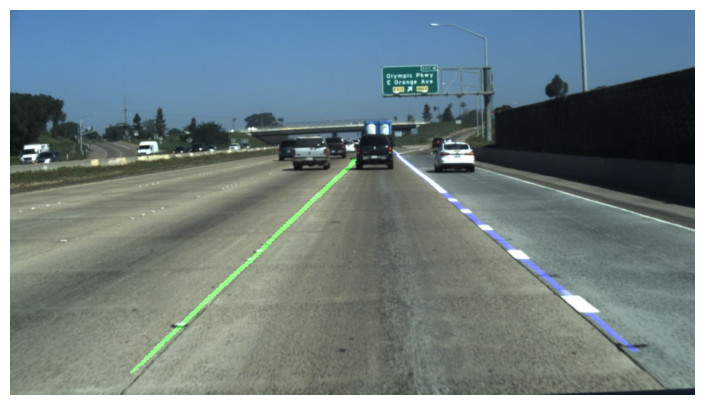

Existence Probs: [0.9999999  0.9999912  0.9969464  0.9976954  0.01054098]


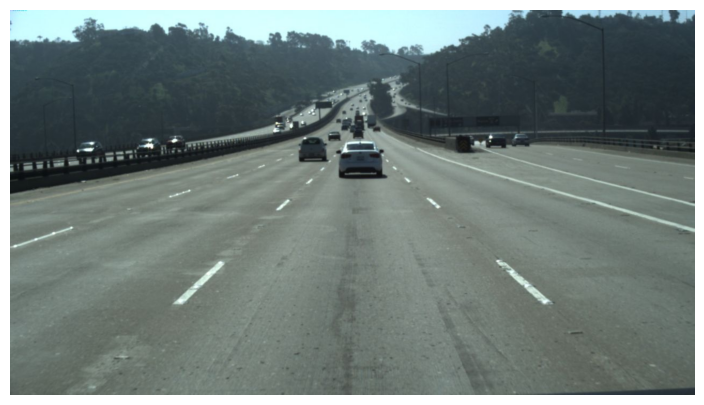

Existence Probs: [0.99999833 0.9999403  0.9991554  0.97925913 0.61667323]


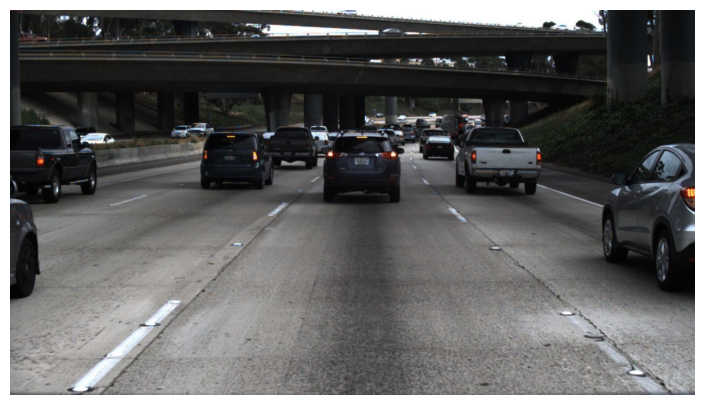

In [33]:
# inference
test_image_path1 = os.path.join(TRAIN_SET_DIR, 'clips/0313-2/50/10.jpg') # Example image
test_image_path2 = os.path.join(TRAIN_SET_DIR, 'clips/0313-1/1800/10.jpg') 
test_image_path3 = os.path.join(TRAIN_SET_DIR, 'clips/0601/1494452553518276564/20.jpg') 
lane_detection_prediction(test_image_path1, BEST_MODEL_PATH, 'instance_result.jpg')
lane_detection_prediction(test_image_path2, BEST_MODEL_PATH, 'instance_result2.jpg')
lane_detection_prediction(test_image_path3, BEST_MODEL_PATH, 'instance_result3.jpg')

## 8. Evaluation
Calculate IoU and Accuracy on the Test Set.


In [59]:
def calculate_tolerance_iou(pred_mask, true_mask, num_classes, tolerance=5):
    # Tolerance IoU: Dilate GT
    iou_per_class = []
    kernel = np.ones((tolerance, tolerance), np.uint8)
    
    for cls in range(num_classes):
        if cls == 0: 
            # standard IoU
            p = (pred_mask == cls)
            t = (true_mask == cls)
            inter = np.logical_and(p, t).sum()
            union = np.logical_or(p, t).sum()
            iou_per_class.append(inter / union if union > 0 else np.nan)
            continue

        pred_cls = (pred_mask == cls).astype(np.uint8)
        true_cls = (true_mask == cls).astype(np.uint8)
        
        # dilate ground truth
        dilated_true = cv2.dilate(true_cls, kernel, iterations=1)
        
        intersection = np.logical_and(pred_cls, dilated_true).sum()
        union = np.logical_or(pred_cls, true_cls).sum()
        
        if union == 0:
            iou_per_class.append(np.nan)
        else:
            iou_per_class.append(intersection / union)
            
    return iou_per_class


In [60]:
def evaluate(model, test_loader, device, val_cm_path=None, plotmode=False, num_visualize=3, save_cm_path=None):
    model.eval()
    
    colors = [[0, 0, 0], [0, 255, 0], [255, 0, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255]]
    viz_samples = []
    
    test_cm = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int64)
    total_tol_iou = []
    
    if not plotmode and val_cm_path and os.path.exists(val_cm_path):
        val_cm = np.load(val_cm_path)
        v_inter = np.diag(val_cm); v_union = val_cm.sum(axis=1) + val_cm.sum(axis=0) - v_inter
        val_iou = v_inter / np.maximum(v_union, 1); v_tp = v_inter
        v_fp = val_cm.sum(axis=0) - v_tp; v_fn = val_cm.sum(axis=1) - v_tp
        val_f1 = 2 * v_tp / np.maximum(2 * v_tp + v_fp + v_fn, 1)
        print(f"\nValidation Mean IoU: {np.nanmean(val_iou[1:]):.4f}")
        print(f"Validation Mean F1:  {np.nanmean(val_f1[1:]):.4f}")

    with torch.no_grad():
        loader = test_loader if not plotmode else DataLoader(torch.utils.data.Subset(test_loader.dataset, np.random.choice(len(test_loader.dataset), num_visualize, replace=False)), batch_size=1)
        
        for images, b_masks, exist_targets in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            batch_size = images.shape[0]
            gt_masks_np = b_masks.cpu().numpy()
            
            seg_logits, exist_logits = model(images)
            seg_probs = torch.sigmoid(seg_logits).cpu().numpy()
            exist_probs = torch.sigmoid(exist_logits).cpu().numpy()
            
            for b in range(batch_size):
                post_masks = apply_advanced_post_processing(seg_probs[b], exist_probs[b], IMG_HEIGHT, IMG_WIDTH)
                
                pred_label_map = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
                gt_label_map = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
                raw_label_map = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
                
                for i in range(NUM_LANE_CLASSES):
                    pred_label_map[post_masks[i] == 1] = i + 1
                    gt_label_map[gt_masks_np[b, i] == 1] = i + 1
                    raw_label_map[seg_probs[b, i] > 0.5] = i + 1
                
                # Calculate Tolerance IoU for metrics
                tol_iou_list = calculate_tolerance_iou(pred_label_map, gt_label_map, NUM_CLASSES, tolerance=5)
                
                if not plotmode:
                    p_flat, t_flat = pred_label_map.flatten(), gt_label_map.flatten()
                    bins = NUM_CLASSES * t_flat + p_flat
                    test_cm += np.bincount(bins, minlength=NUM_CLASSES**2).reshape(NUM_CLASSES, NUM_CLASSES)
                    total_tol_iou.append(tol_iou_list)
                
                if len(viz_samples) < num_visualize:
                    # Filter out absent lanes from the visual average to be honest
                    # A lane is only counted if it exists in GT.
                    valid_ious = []
                    for c in range(1, NUM_CLASSES):
                        if (gt_label_map == c).sum() > 0:
                            valid_ious.append(tol_iou_list[c])
                    
                    mean_viz_iou = np.mean(valid_ious) if valid_ious else 0.0
                    
                    img_np = (images[b].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
                    viz_samples.append((img_np, gt_label_map, pred_label_map, raw_label_map, mean_viz_iou))

    if not plotmode:
        t_inter = np.diag(test_cm); t_union = test_cm.sum(axis=1) + test_cm.sum(axis=0) - t_inter
        test_iou = t_inter / np.maximum(t_union, 1)
        test_f1 = 2 * t_inter / np.maximum(2 * t_inter + (test_cm.sum(axis=0) - t_inter) + (test_cm.sum(axis=1) - t_inter), 1)
        mean_tol_iou = np.nanmean(total_tol_iou, axis=0)
        
        print(f"Test Mean IoU:       {np.nanmean(test_iou[1:]):.4f}")
        print(f"Test Mean F1:        {np.nanmean(test_f1[1:]):.4f}")
        print(f"Test Mean Tol IoU:   {np.nanmean(mean_tol_iou[1:]):.4f}\n")
        
        if save_cm_path:
            np.save(save_cm_path, test_cm)
            print(f"Test Confusion Matrix saved to: {save_cm_path}")
        
        plt.figure(figsize=(8, 6)); plt.imshow(test_cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Test Confusion Matrix'); plt.colorbar(); plt.show()
    
    if len(viz_samples) > 0:
        rows = len(viz_samples)
        fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows), squeeze=False)
        for idx, (img, gt, pred, raw, m_iou) in enumerate(viz_samples):
            axes[idx, 0].imshow(img); axes[idx, 0].set_title("Input"); axes[idx, 0].axis('off')
            ov_gt, ov_pred, ov_raw = img.copy(), img.copy(), img.copy()
            for c in range(1, NUM_CLASSES):
                 ov_gt[gt==c] = colors[c]; ov_pred[pred==c] = colors[c]; ov_raw[raw==c] = colors[c]
            axes[idx, 1].imshow(ov_gt); axes[idx, 1].set_title("Ground Truth"); axes[idx, 1].axis('off')
            axes[idx, 2].imshow(ov_raw); axes[idx, 2].set_title("Raw Preds (>0.5)"); axes[idx, 2].axis('off')
            axes[idx, 3].imshow(ov_pred); axes[idx, 3].set_title(f"Filtered | Mean Tol-IoU: {m_iou:.3f}"); axes[idx, 3].axis('off')
        plt.show()

Processing test_label.json: 100%|██████████| 2782/2782 [00:06<00:00, 416.49it/s]



Validation Mean IoU: 0.4401
Validation Mean F1:  0.5994


Evaluating: 100%|██████████| 174/174 [40:56<00:00, 14.12s/it]


Test Mean IoU:       0.0472
Test Mean F1:        0.0813
Test Mean Tol IoU:   0.0831

Test Confusion Matrix saved to: c:\Users\Alex\Documents\Clase\Italia\Segundo_ano\ADAS\Project\ADAS-Project\checkpoints\instance\test_confusion_matrix.npy


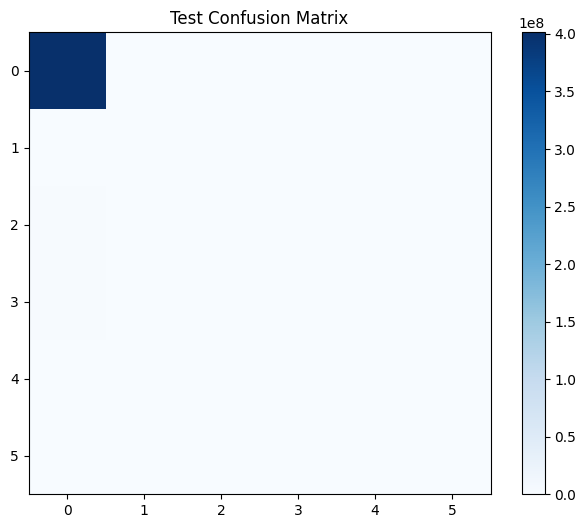

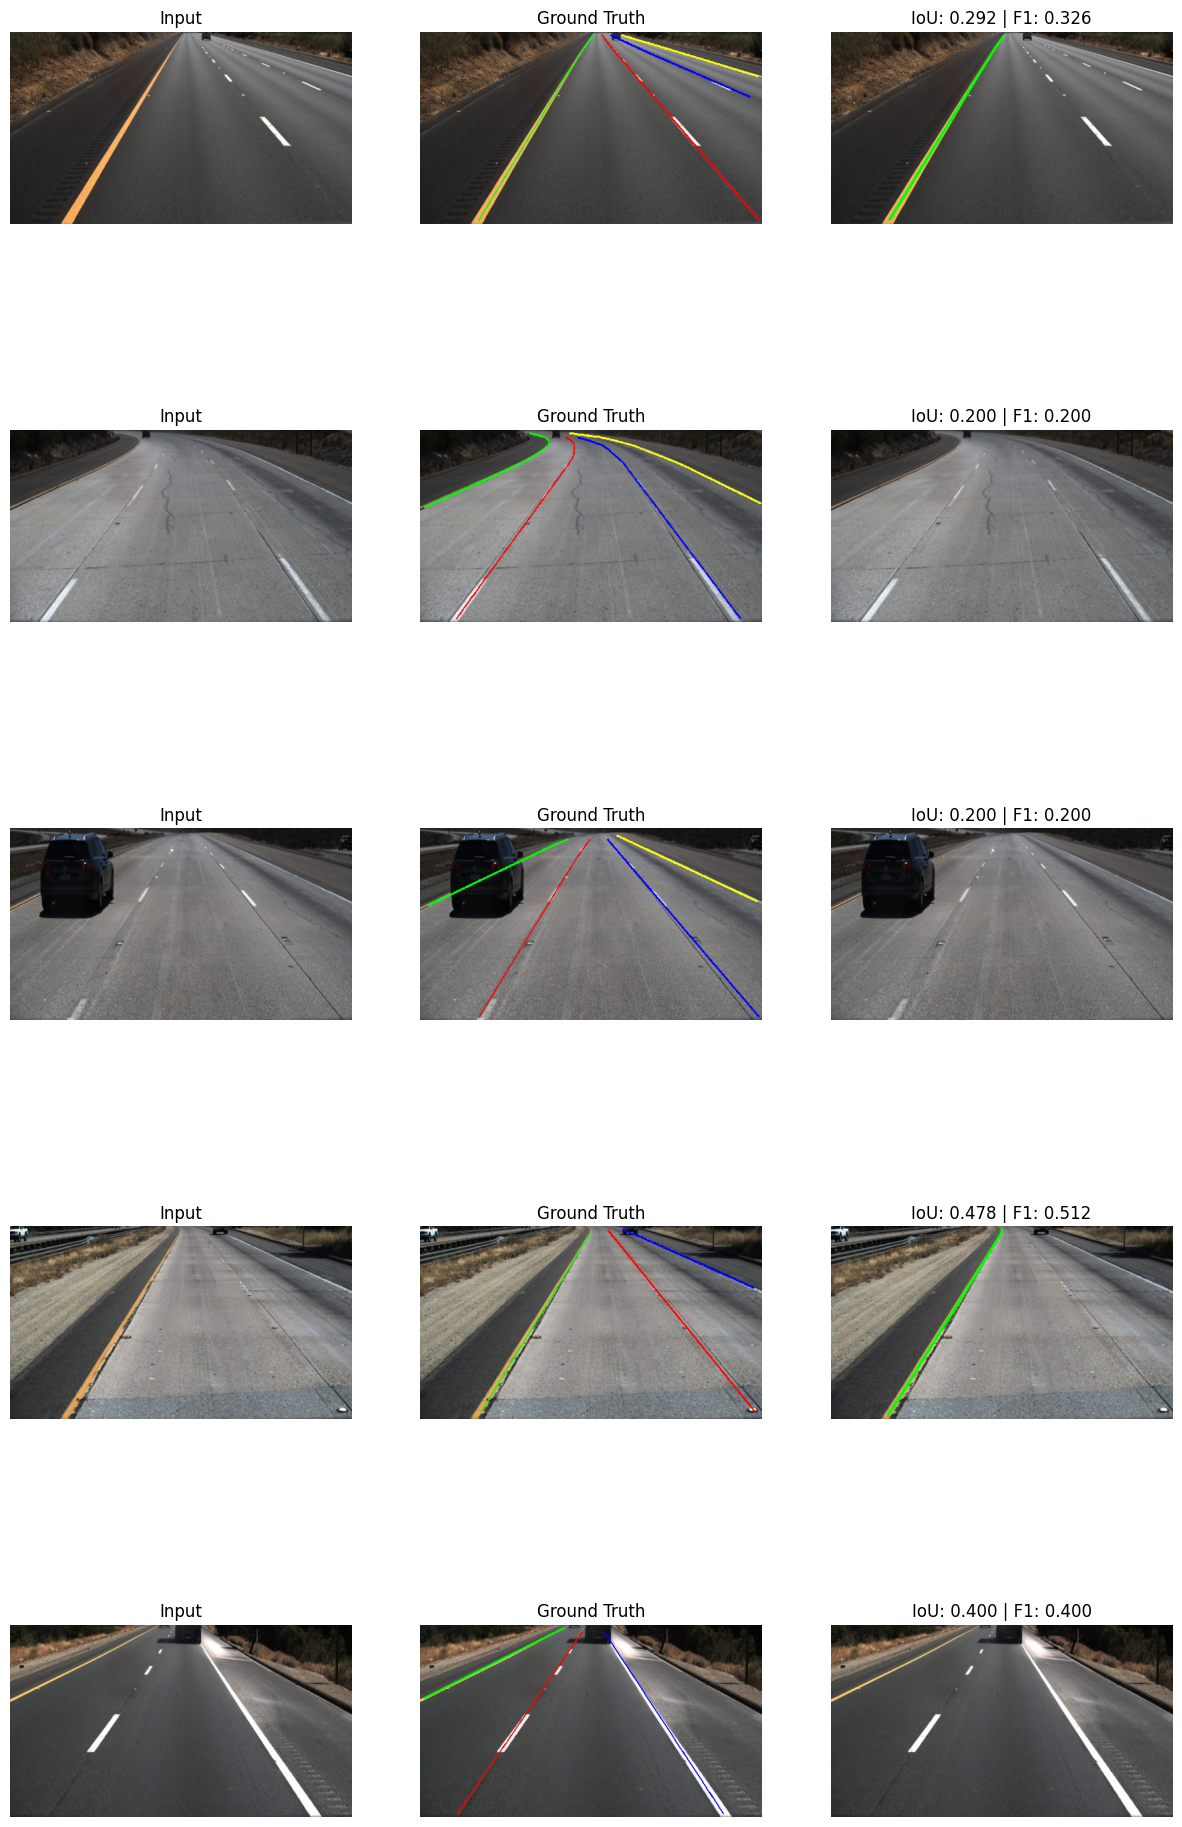

In [37]:
test_json_files = ['test_label.json']
process_tusimple_data(TEST_SET_DIR, PROCESSED_DATA_DIR, test_json_files)

test_dataset = TuSimpleDataset(TEST_SET_DIR, PROCESSED_DATA_DIR, test_json_files)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UNet(n_channels=3, n_lane_classes=NUM_LANE_CLASSES).to(device)
model.load_state_dict(torch.load(BEST_MODEL_PATH, map_location=device))

val_cm_path = os.path.join(CHECKPOINT_DIR, f"confusion_matrix_e{EPOCHS}.npy")

save_test_cm_path = os.path.join(CHECKPOINT_DIR, 'test_confusion_matrix.npy')
evaluate(model, test_loader, device, val_cm_path=val_cm_path, plotmode=False, num_visualize=5, save_cm_path=save_test_cm_path)

Evaluating: 100%|██████████| 30/30 [00:03<00:00,  9.92it/s]


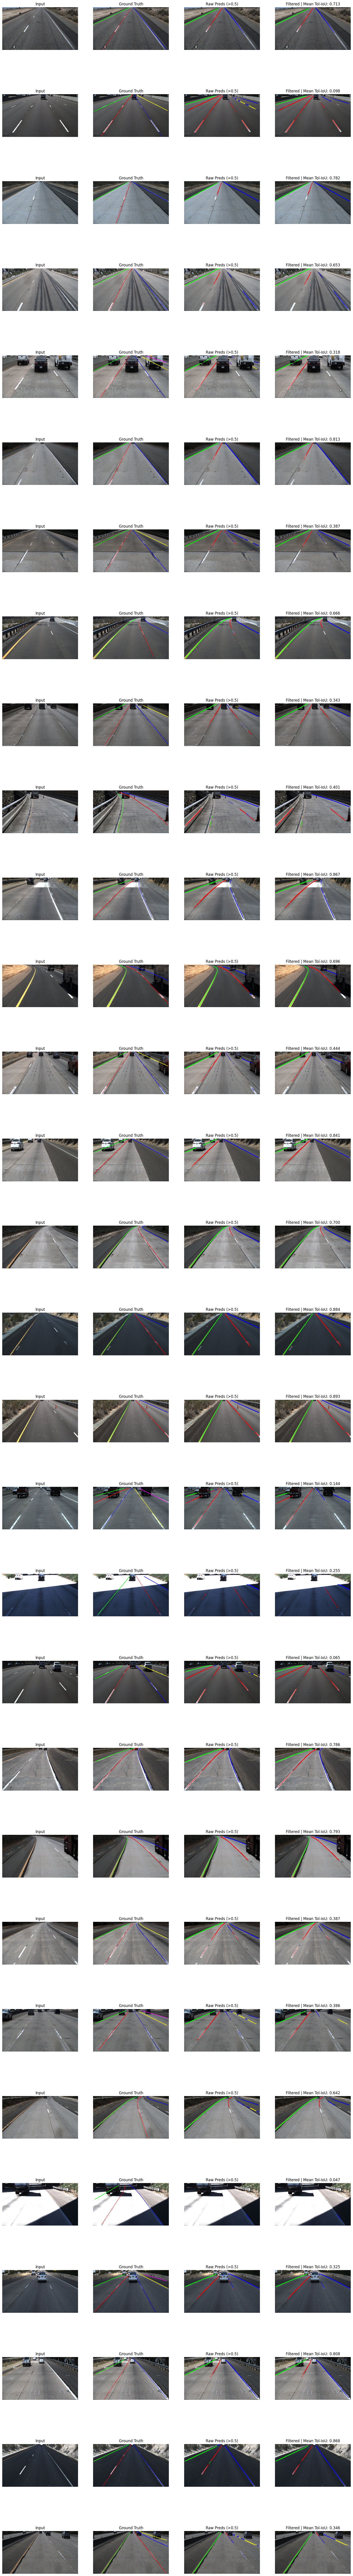

In [61]:
evaluate(model, test_loader, device, val_cm_path=val_cm_path, plotmode=True, num_visualize=30)